In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [57]:
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged_covid.csv'

In [6]:
file_path2 = '/content/drive/My Drive/X999/svi_cleaned.csv'

In [7]:
bbl_evictions_df = pd.read_csv(file_path1)

In [8]:
svi_df = pd.read_csv(file_path2)

In [12]:
columns_list = ['FIPS', 'E_TOTPOP', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
               'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR','EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_LIMENG',
               'EP_NOVEH', 'EP_CROWD', 'EP_HBURD','EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', 'EP_NHPI', 'EP_TWOMORE',
                'EP_OTHERRACE', 'EP_MINRTY']

In [13]:
# the cleaned svi df has changed all columns to lower case, so we will do it here too.
lowercase_columns = [col.lower() for col in columns_list]

In [14]:
lowercase_columns[:5]

['fips', 'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3']

In [15]:
svi_simplified = svi_df[lowercase_columns]
svi_simplified.head()

,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,...,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty
0,10001,27004,0.5688,0.1692,0.8670,0.9806,0.7414,20.3,4.3,9.1,...,2.7,23.1,8.2,19.3,18.6,0.0,0.0,2.9,0.8,49.8
1,10002,76518,0.9639,0.8781,0.9369,0.9254,0.9656,36.8,7.6,30.0,...,6.8,40.8,8.0,26.0,37.2,0.1,0.0,2.4,0.8,74.4
2,10003,53877,0.3389,0.0969,0.7977,0.9368,0.5373,14.3,4.7,4.2,...,3.2,21.8,5.4,10.3,16.7,0.1,0.1,3.8,0.3,36.7
3,10004,4579,0.0252,0.0769,0.8439,0.8558,0.2299,3.7,0.4,0.9,...,7.6,6.1,5.5,5.0,29.9,0.0,0.0,3.5,0.0,43.9
4,10005,8801,0.0631,0.0427,0.7504,0.8496,0.2437,7.4,3.4,2.5,...,8.4,10.9,4.8,8.6,11.2,0.0,0.0,6.5,0.0,31.0


In [16]:
svi_df.shape, svi_simplified.shape

((204, 156), (204, 26))

In [17]:
svi_simplified['ep_white'] = 100 - svi_simplified['ep_minrty']

In [19]:
bbl_evictions_df.eviction_postcode.dtype, svi_simplified.fips.dtype

(dtype('int64'), dtype('int64'))

In [20]:
bbl_evictions_df['eviction_postcode'] = bbl_evictions_df['eviction_postcode'].astype(str)
svi_simplified['fips'] = svi_simplified['fips'].astype(str)

In [59]:
bbl_evictions_df.bbl.dtype

dtype('float64')

In [68]:
bbl_evictions_df['bbl'] = bbl_evictions_df.bbl.astype(int)

In [69]:
merged_df = pd.merge(bbl_evictions_df,
                    svi_simplified,
                    left_on='eviction_postcode',
                    right_on='fips',
                    how='left')

### Check nan

In [70]:
nan_values = merged_df.isna().sum()
nan_values, \
nan_values.sum()

(court_index_number             0
 docket_number                  0
 eviction_address               0
 eviction_apartment_number      0
 executed_date                  0
                             ... 
 ep_nhpi                      111
 ep_twomore                   111
 ep_otherrace                 111
 ep_minrty                    111
 ep_white                     111
 Length: 67, dtype: int64,
 np.int64(8649))

In [71]:
nan_values

,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,0
executed_date,0
...,...
ep_nhpi,111
ep_twomore,111
ep_otherrace,111
ep_minrty,111


In [72]:
display(merged_df[merged_df.isna().any(axis=1)])

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,geometry,eviction_count,year,average_year_eviction_count,bbl_clean,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white
1,251388/19,117473,160 EAST 117 STREET,3-B,2020-01-02,MANHATTAN,10035,Not an Ejectment,Possession,40.799094,-73.940658,11.0,8.0,182.0,1052311.0,1016447502,East Harlem North,POINT (-73.940658 40.799094),1,2020,1.0,1016447502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10035,38595.0,0.9903,0.9692,0.9656,0.9709,0.9914,46.2,10.7,24.9,7.4,14.3,21.3,18.9,8.7,83.9,8.4,45.1,36.7,43.0,3.4,0.1,0.0,3.4,0.3,87.0,13.0
34,64888/19,12127,70 PINE STREET,3807,2020-01-02,MANHATTAN,10005,Not an Ejectment,Possession,40.706315,-74.007895,1.0,1.0,7.0,1001007.0,1000417504,Battery Park City-Lower Manhattan,POINT (-74.007895 40.706315),12,2020,1.0,1000417504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10005,8801.0,0.0631,0.0427,0.7504,0.8496,0.2437,7.4,3.4,2.5,1.2,1.8,10.5,1.1,0.3,92.3,8.4,10.9,4.8,8.6,11.2,0.0,0.0,6.5,0.0,31.0,69.0
79,71988/19,100085,54 VERMONT STREET,3RD FLOOR,2020-01-03,BROOKLYN,11207,Not an Ejectment,Possession,40.678710,-73.895641,5.0,37.0,1146.0,3391944.0,3036610120,Cypress Hills-City Line,POINT (-73.895641 40.67871),1,2020,1.0,3036610120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11207,96801.0,0.9788,0.9140,0.9808,0.9812,0.9839,33.9,11.1,19.1,6.0,13.8,22.5,13.8,5.3,57.8,9.1,44.7,55.9,32.8,1.5,0.0,0.0,2.9,1.6,94.7,5.3
93,50525/19,25994,711C SEAGIRT AVENUE,12G,2020-01-03,QUEENS,11691,Not an Ejectment,Possession,40.595996,-73.742187,14.0,31.0,101002.0,4298968.0,4156100001,Far Rockaway-Bayswater,POINT (-73.742187 40.595996),109,2020,4.0,4156100001,1974.0,D1,25.0,917.0,"HP SEA GIRT HOUSING DEV FUND COMPANY, IN C",744719.0,post-war,elevator,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1970-1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,68156/19,25734,153-30 89TH AVE,220,2020-01-06,QUEENS,11432,Not an Ejectment,Possession,40.705517,-73.802501,12.0,24.0,240.0,4208831.0,4097557501,Jamaica,POINT (-73.802501 40.705517),30,2020,1.5,4097557501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11432,64268.0,0.9558,0.7852,0.9668,0.9983,0.9713,23.5,8.2,19.1,9.2,16.8,20.9,10.9,16.1,41.0,17.4,40.7,16.8,21.0,42.8,0.7,0.1,5.0,1.5,88.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,301252/22,28446,236 BEACH 87 STREET,1,2022-12-15,QUEENS,11693,Not an Ejectment,Possession,40.588152,-73.812217,14.0,32.0,94202.0,4435874.0,4161200014,Hammels-Arverne-Edgemere,POINT (-73.812217 40.588152),1,2022,1.0,4161200014,1901.0,C0,2.5,3.0,SEVEN EIGHT SIX INC,1964.0,pre-war,walk-up,False,low-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",3-5 units,False,very small,Q2 (25-50%),1900-1909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6250,322135/22,109713,1510 

In [73]:
merged_df.shape

(6338, 67)

## After merging bbl_evictions_df and svi_simplified, we check nan, since rpl_themes is the most import column and any rows that have nan

In [31]:
merged_df.shape

(6338, 67)

In [39]:
nan_rows = merged_df[merged_df['rpl_themes'].isna()]
nan_rows # the zipcodes were not matches in this case and all the svi columns are nan

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white
93,50525/19,25994,711C SEAGIRT AVENUE,12G,2020-01-03,QUEENS,11691,Not an Ejectment,Possession,40.595996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,56103/19,17574,711B SEAGIRT AVE,17B,2020-01-06,QUEENS,11691,Not an Ejectment,Possession,40.595996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,56782/19,17576,711B SEAGIRT AVE,17A,2020-01-06,QUEENS,11691,Not an Ejectment,Possession,40.595996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,68130/19,100706,539 BEACH 19TH ST,1ST FL-ENTIRE,2020-01-08,QUEENS,11691,Not an Ejectment,Possession,40.600047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,66812/19,26223,1011 NAMEOKE AVENUE,LF,2020-01-08,QUEENS,11691,Not an Ejectment,Possession,40.603191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,302632/21,28349,20-39 SEAGIRT BOULEVARD,01E,2022-12-02,QUEENS,11691,Not an Ejectment,Possession,40.595188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6093,54568/20,106781,51-45 ALMEDA AVENUE,5F,2022-12-06,QUEENS,11691,Not an Ejectment,Possession,40.597793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6098,064256/19,102466,51-15 ALMEDA AVENUE,3C,2022-12-06,QUEENS,11691,Not an Ejectment,Possession,40.597793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6191,67795/19,25964,161 BEACH FIFTH STREET,A,2022-12-12,QUEENS,11691,Not an Ejectment,Possession,40.595610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
missing_svi = merged_df['rpl_themes'].isna().sum()
print(missing_svi/len(merged_df)*100,"% missing rows")

1.7513411170716315 % missing rows


In [41]:
missing_svi # 111 rows

np.int64(111)

In [43]:
missing_postcodes = merged_df[merged_df['rpl_themes'].isna()]['eviction_postcode'].unique()
missing_postcodes

array(['11691', '11692', '11694', '11693', '11040'], dtype=object)

These zipcodes do not have matches. Roughly these neighborhoods: Neighborhoods:
Far Rockaway, Bayswater, Edgemere, Arverne, Rockaway Beach, Hammels, Belle Harbor, Neponsit,
Rockaway Park, Broad Channel, New Hyde Park, Garden City Park, Herricks, North New Hyde Park

In [44]:
merged_df_clean = merged_df[~merged_df['eviction_postcode'].isin(missing_postcodes)]
merged_df.shape, merged_df_clean.shape, len(merged_df) - len(merged_df_clean)

((6338, 67), (6227, 67), 111)

In [ ]:
# merged_df_clean.columns

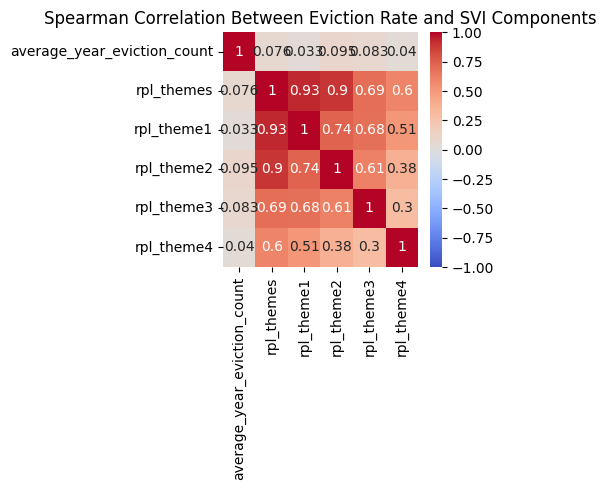

In [45]:
key_vars = ['average_year_eviction_count', 'rpl_themes', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
correlation_heatmap = merged_df_clean[key_vars].corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_heatmap, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Between Eviction Rate and SVI Components')
plt.tight_layout()
plt.savefig('eviction_svi_correlation.png')

In [46]:
key_vars = ['average_year_eviction_count', 'rpl_themes', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
correlation_results = {}

for var in key_vars[1:]:
    correlation, p_value = stats.spearmanr(merged_df_clean['average_year_eviction_count'], merged_df_clean[var])
    correlation_results[var] = {'correlation': correlation, 'p_value': p_value}

for var, results in correlation_results.items():
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    print(f"correlation between eviction rate and {var}: r = {results['correlation']:.3f}, p = {results['p_value']:.4f} ({significance})")

correlation between eviction rate and rpl_themes: r = 0.076, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme1: r = 0.033, p = 0.0099 (significant)
correlation between eviction rate and rpl_theme2: r = 0.095, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme3: r = 0.083, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme4: r = 0.040, p = 0.0014 (significant)


very weak correlations between SVI and evictions during Covid.

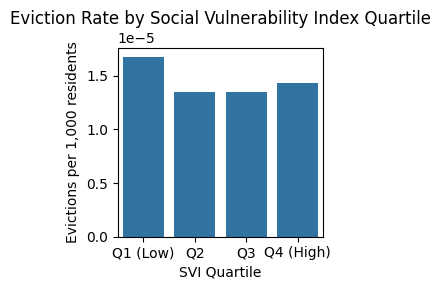

In [48]:
merged_df_clean['svi_quartile'] = pd.qcut(merged_df_clean['rpl_themes'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_analysis = merged_df_clean.groupby('svi_quartile').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'e_totpop': 'sum'
}).reset_index()
quartile_analysis['total_eviction_rate'] = quartile_analysis['average_year_eviction_count'] / quartile_analysis['e_totpop'] * 1000
plt.figure(figsize=(3, 3))
sns.barplot(x='svi_quartile', y='total_eviction_rate', data=quartile_analysis)
plt.title('Eviction Rate by Social Vulnerability Index Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('SVI Quartile')
plt.tight_layout()
plt.savefig('eviction_by_svi_quartile.png')

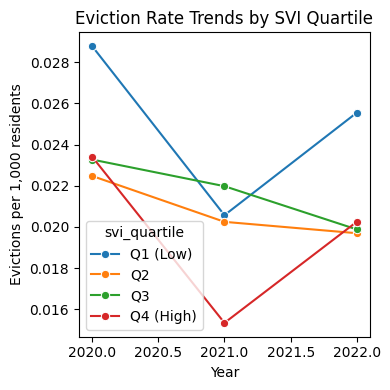

In [50]:
time_analysis = merged_df_clean.groupby(['year', 'svi_quartile']).agg({
    'average_year_eviction_count': 'sum',
    'e_totpop': 'sum'
}).reset_index()
time_analysis['yearly_eviction_rate'] = time_analysis['average_year_eviction_count'] / time_analysis['e_totpop'] * 1000

plt.figure(figsize=(4, 4))
sns.lineplot(x='year', y='yearly_eviction_rate', hue='svi_quartile', data=time_analysis, marker='o')
plt.title('Eviction Rate Trends by SVI Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('eviction_trends_svi.png')

during covid, svi is simply not does not have strong correlation with the evictions, likely due to the fact that people who had fairly stable socialeconomic power chose to leave nyc before an lease ended.